**Processing gsets and evaluating KL**

In [1]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx
import numba as nb
from sklearn.manifold import SpectralEmbedding
from tqdm import tqdm
from sklearn.cluster import SpectralClustering
import seaborn as sns
import metis
import numba as nb
import numpy as np

from ABCA7lof2.geneclusters import compute_jaccard, compute_all_jaccard, get_rand_index, get_LP, get_spectral_partition, evaluate_cut, get_scores, compute_jaccard_all_clust, get_all_rands, get_all_rands2grps, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite, plot_component, plot_edges, plot_nodes, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, compute_groupped_matrix, get_full_matrix_from_bipartite

#### Saving the gsets

In [ ]:
# save the gsets
p1 = np.load('./raw_data/genesets/WikiPathways_2019_Human.npy', allow_pickle=True).item()
res = {**p1}
np.save('./processed_data/genesets/all_paths.npy', res)
pd.DataFrame.from_dict(res, orient='index').to_csv('./processed_data/genesets/all_paths.csv')

In [40]:
p1 = np.load('./raw_data/genesets/GO_Biological_Process_2023.npy', allow_pickle=True).item()


#### Subset matrix of interest

In [3]:
# subset matrix
mat = get_gene_pathway_matrix('./processed_data/genesets/all_paths.npy')
leading_edge = './processed_data/for_plotting/leading_edge_0825Ex.csv'
leading_edge = pd.read_csv(leading_edge, index_col=0)
S = set(leading_edge['gene'])

col_index = np.where([x in S for x in mat.columns])[0]
mat_sub = mat.iloc[:,col_index]

path_index = (np.sum(mat_sub, axis=1)>4)
mat_sub = mat_sub.loc[path_index]
mat_sub = mat_sub.loc[:,np.sum(mat_sub, axis=0)>0]

#### Plot Jaccard indices pre clustering

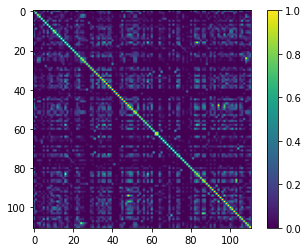

In [72]:
# get pathway gene matrix
mat_array = np.array(mat_sub)
out = compute_all_jaccard(mat_array)

embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(out)

plt.imshow(out, cmap='viridis')
plt.colorbar()
plt.savefig('./pdf_figures/jaccard_mat_sub.pdf')

In [90]:
np.mean(np.sum(out>0, axis=0)/out.shape[0])

0.4286178069961854

### import the KL and metis partitions

In [9]:
kl_loss = np.load('./processed_data/genesets/kl_loss.npy')
kl_labs = np.load('./processed_data/genesets/kl_labs.npy')

In [10]:
metis_loss = np.load('./processed_data/genesets/met_loss.npy')
metis_labs = np.load('./processed_data/genesets/met_labs.npy')

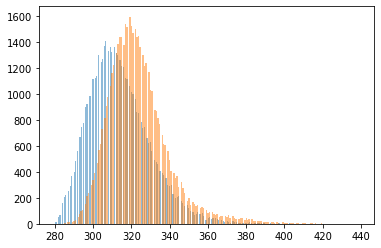

In [20]:
plt.hist(metis_loss, 200, alpha=0.5)
None
plt.hist(kl_loss, 200, alpha=0.5)
None

In [11]:
get_rand_index(kl_labs[np.argmin(kl_loss)], metis_labs[np.argmin(metis_labs)])

0.908702946930194

### spectral bissection

In [13]:
# compute laplacian matrix
full_mat = np.zeros((np.sum(mat_sub.shape), np.sum(mat_sub.shape)))
full_mat[mat_sub.shape[1]:][:,:mat_sub.shape[1]] = mat_sub
full_mat[:mat_sub.shape[1]][:,mat_sub.shape[1]:]=mat_sub.T

i=0
nclust = 8
it = int(np.log2(nclust))
labels_sp = np.zeros((nclust,full_mat.shape[0]))

for x in range(it):
    grps = np.unique(labels_sp, axis=1)
    index = [[np.unique(labels_sp[:,x]==grps[:,y])[0] for x in range(labels_sp.shape[1])] for y in range(grps.shape[1])]
    for j in range(len(index)):
        get_spectral_partition(labels_sp,  get_LP(full_mat[index[j]][:,index[j]]), i, index[j])
        i+=1
labels_sp = [np.argwhere(np.sum(np.unique(labels_sp, axis=1)-labels_sp[:,x].reshape(-1,1)==0, axis=0)==nclust)[0][0] for x in range(labels_sp.shape[1])] 
loss_sp = evaluate_cut(np.ascontiguousarray(mat_sub.values.T), labels_sp, 0)

### spectral clustering

In [18]:
N=1000
loss_sc=np.empty(N)
labs_sc = np.zeros_like(kl_labs)
for i in tqdm(range(N)): 
    sc = SpectralClustering(8, assign_labels='kmeans', random_state=i, affinity='precomputed').fit(full_mat)
    loss_sc[i]=evaluate_cut(np.ascontiguousarray(mat_sub.values.T), sc.labels_, 0)
    labs_sc[i] = sc.labels_

100%|██████████| 1000/1000 [02:59<00:00,  5.59it/s]


### Random partitioning

In [20]:
labs_rand = kl_labs.copy()
loss_rand = np.empty(N)

for i in tqdm(range(N)):
    L = np.random.permutation(kl_labs[0])
    labs_rand[i] = L
    loss_rand[i] = evaluate_cut(np.ascontiguousarray(mat_sub.values.T), L, 0)

100%|██████████| 1000/1000 [00:12<00:00, 79.86it/s]


### plot loss

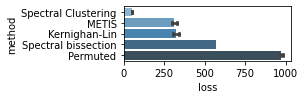

In [23]:
# plot loss by method for cluster size 8

df = pd.DataFrame(np.concatenate((loss_sc,metis_loss, kl_loss, np.array([loss_sp]), loss_rand)))
df['method'] = np.concatenate((np.repeat('Spectral Clustering', N),np.repeat('METIS', len(kl_loss)), (np.repeat('Kernighan-Lin', len(kl_loss))), ['Spectral bissection'], np.repeat('Permuted', N)))
df.columns = ['loss', 'method']

plt.figure(figsize=(3,1))

sns.barplot(data=df, x="loss", y="method", estimator=np.mean, ci='sd', capsize=.2, color='lightblue', palette = "Blues_d")
plt.savefig('./pdf_figures/losses.pdf')

### Rand indices

In [50]:
N=1000

In [51]:
kl_RI = np.empty((N,N))
get_all_rands(kl_RI, N, kl_labs)

met_RI = np.empty((N,N))
get_all_rands(met_RI, N, metis_labs)

rand_RI = np.empty((N,N))
get_all_rands(rand_RI, N, labs_rand)


In [52]:
kl_metis_RI = np.empty((N,N))
get_all_rands2grps(kl_metis_RI, N, metis_labs, kl_labs)

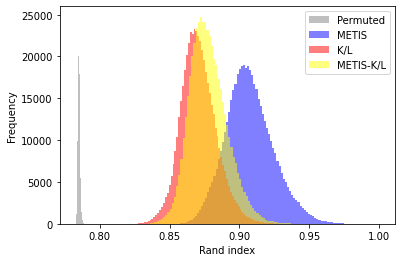

In [62]:
plt.hist(rand_RI[np.tril_indices_from(rand_RI, k=-1)],bins=100, color='grey', alpha=0.5, label='Permuted')
plt.hist(met_RI[np.tril_indices_from(met_RI, k=-1)],bins=100, color='blue', alpha=0.5, label = 'METIS')
plt.hist(kl_RI[np.tril_indices_from(kl_RI, k=-1)],bins=100, color='red', alpha=0.5, label = 'K/L')
plt.hist(kl_metis_RI[np.tril_indices_from(kl_metis_RI, k=-1)],bins=100, color='yellow', alpha=0.5, label = 'METIS-K/L')
plt.legend()
plt.xlabel('Rand index')
plt.ylabel('Frequency')

None
plt.savefig('./pdf_figures/rand_indices_hist.pdf')

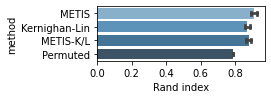

In [56]:
# plot rand by method for cluster size 8

df = pd.DataFrame(np.concatenate((met_RI[np.tril_indices_from(met_RI, k=-1)],kl_RI[np.tril_indices_from(kl_RI, k=-1)],kl_metis_RI[np.tril_indices_from(kl_metis_RI, k=-1)], rand_RI[np.tril_indices_from(rand_RI, k=-1)])))
n = len(sc_RI[np.tril_indices_from(sc_RI, k=-1)])
df['method'] = np.concatenate((np.repeat('METIS', n), np.repeat('Kernighan-Lin', n), np.repeat('METIS-K/L', n), np.repeat('Permuted', n)))
df.columns = ['Rand index', 'method']

plt.figure(figsize=(3,1))

sns.barplot(data=df, x="Rand index", y="method", estimator=np.mean, ci='sd', capsize=.2, color='lightblue', palette = "Blues_d")
plt.savefig('./pdf_figures/rand_indices.pdf')

#### Plot jaccard indices

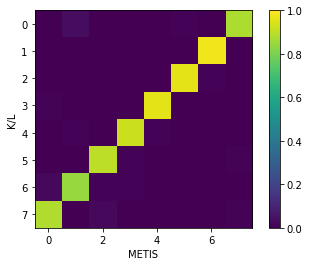

In [32]:
temp = compute_jaccard_all_clust(kl_labs[np.argmin(kl_loss)], metis_labs[np.argmin(metis_loss)])
T = temp

o = [7,1,4,6,0,3,2,5]
plt.imshow(temp[o].T, cmap='viridis', vmax=1, vmin=0)
plt.colorbar()
plt.ylabel('K/L')
plt.xlabel('METIS')
plt.savefig('./pdf_figures/argmins_jaccard.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


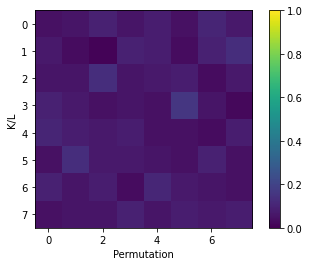

In [211]:
# plot jaccard for Kl_loss and rand permutation

temp = compute_jaccard_all_clust(kl_labs[np.argmin(kl_loss)], labs_rand[np.argmin(loss_rand)])
T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(temp, cmap='viridis', vmax=1, vmin=0)
plt.colorbar()
plt.ylabel('K/L')
plt.xlabel('Permutation')

plt.savefig('./pdf_figures/random_jaccard.pdf')

#### plot adjacency matrix for one example of each method

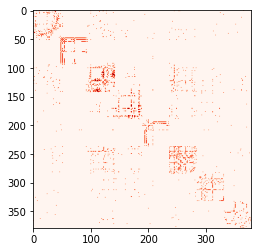

In [14]:
plt.imshow(full_mat[np.argsort(kl_labs[np.argmin(kl_loss)])][:,np.argsort(kl_labs[np.argmin(kl_loss)])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_KL_cluster.pdf')

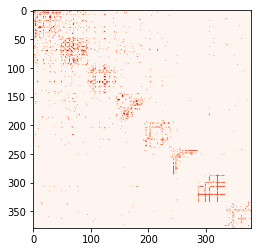

In [15]:
# plot adjacency matrix for one example of each method
plt.imshow(full_mat[np.argsort(metis_labs[np.argmin(metis_loss)])][:,np.argsort(metis_labs[np.argmin(metis_loss)])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_metis_cluster.pdf')

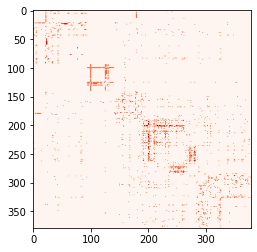

In [16]:
# plot adjacency matrix for one example of each method
plt.imshow(full_mat[np.argsort(labels_sp)][:,np.argsort(labels_sp)], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_SP_cluster.pdf')

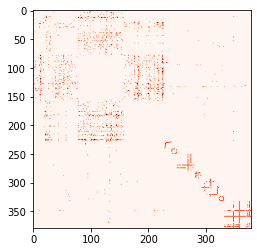

In [19]:
# plot adjacency matrix for one example of each method
plt.imshow(full_mat[np.argsort(labs_sc[np.argmin(loss_sc)])][:,np.argsort(labs_sc[np.argmin(loss_sc)])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_SC_cluster.pdf')

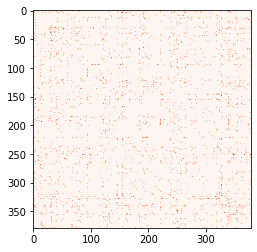

In [21]:
plt.imshow(full_mat[np.argsort(labs_rand[np.argmin(loss_rand)])][:,np.argsort(labs_rand[np.argmin(loss_rand)])], vmin=0, vmax=1, cmap='Reds')
plt.savefig('./pdf_figures/adj_by_uniform_cluster.pdf')